In [1]:
#In this notebook we use segmential regresion, that is to say, we make predictors separately
#for different predicted price segments

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display
pd.options.display.max_columns = None

%matplotlib inline

#load variables
%store -r qual_encoded
%store -r binary_encoded
%store -r quantitativesr
%store -r clustnames
%store -r binvars

#ok, ready for models..

train_df = pd.read_csv('train_df_processed.csv')
combi_sr=pd.read_csv('combi_df_FE.csv',index_col=[0,1])

L1res=pd.DataFrame(index=combi_sr.index)
Y_train=pd.DataFrame()
Y_train['Price'] = train_df["SalePrice"]

#log transform the saleprice
Y_train['Price']=np.log1p(Y_train.values)

del(train_df)

#set all used variables to
variables_all=qual_encoded+binary_encoded+quantitativesr+clustnames

/Users/akutvone/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


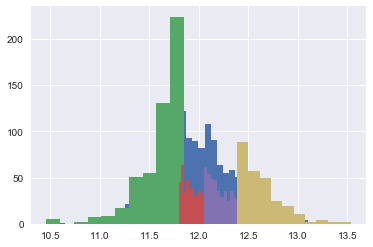

In [2]:
#seems like suitable to try 3 different bins on maximum, but let's make 4 bins and let the overlap to increase data and
#increase the probability that entries are classified

trainlen=Y_train.shape[0]
Y_train['Price'].hist(bins=50)
Y_train['Price'].sort_values()[0:500].hist()
Y_train['Price'].sort_values()[400:800].hist()
Y_train['Price'].sort_values()[800:1200].hist()
Y_train['Price'].sort_values()[1200:trainlen].hist()


#bin by price values so that each bin contains as many entires
bincuts=4
increment=int(trainlen/bincuts)
Y_train['bins']=0

for i in range(1,bincuts):

    #largest value in the bin
    limit=Y_train['Price'].nsmallest(increment*i).max()

    #smaller than limit and not visited
    binmembers=(Y_train['bins']==0) & (Y_train['Price']<=limit)
    Y_train['bins'][binmembers]=str(i)

#last index is the rest
binmembers=(Y_train['bins']==0)
Y_train['bins'][binmembers]=str(bincuts)

#get dummies for the bins
Y_train=Y_train.join(pd.get_dummies(Y_train['bins'],prefix='bin'))

In [3]:
#map those 4 into 3 bins
b1=Y_train['bin_1']==1
b2=Y_train['bin_2']==1
b3=Y_train['bin_3']==1
b4=Y_train['bin_4']==1

Y_train['B1']=0
Y_train['B2']=0
Y_train['B3']=0

Y_train.loc[b1 | b2,'B1']=1
Y_train.loc[b2 | b3,'B2']=1
Y_train.loc[b3 | b4,'B3']=1

Y_train.head()

#now most of the entries belong to two bins, but it's ok and increases the training data for each bin

,Price,bins,bin_1,bin_2,bin_3,bin_4,B1,B2,B3
0,12.247699,3,0,0,1,0,0,1,1
1,12.109016,3,0,0,1,0,0,1,1
2,12.317171,4,0,0,0,1,0,0,1
3,11.849405,2,0,1,0,0,1,1,0
4,12.429220,4,0,0,0,1,0,0,1


In [4]:
#predict the correct bin for each entry
#use recursive feature elimination with decision tree for each bin and then use random forest for predicting

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso, LassoLarsCV,LinearRegression
from sklearn.feature_selection import RFE

#recursive feature elimination
def RFE_DT(data_df,target):

    DT=DecisionTreeClassifier()

    #rfes
    rfe_DT = RFE(DT)
    rfe_DT.fit(data_df,target) 
   
    #get the coefficients
    coeff_df = pd.DataFrame(data_df.columns)
    coeff_df.columns = ['Feature']
    coeff_df["DT_coeff"]=pd.Series(rfe_DT.ranking_)
    
    #sort
    #display(coeff_df.sort_values(by="DT_coeff",ascending=True))
    
    return coeff_df


#get the significant variables, as small list as possible for avoiding overfitting
def Get_variables_bins(data_df,target,variables):
    
    #it seems good to loop the rank 1 from variables couple of times since most of the variables are given the rank 1
    for i in range(1):
    
        #get the best variables from rfe
        rferesults_df=RFE_DT(data_df.loc['train',variables],target)
        variables=list(rferesults_df.loc[rferesults_df['DT_coeff']<15].sort_values(by='DT_coeff')['Feature'])

        returnvariables=list(rferesults_df.sort_values(by='DT_coeff')['Feature'])
        
    return rferesults_df,returnvariables

#do the ranking itself with random forest
def cvscores_bins(data_df,variables,target):
    model=RandomForestClassifier()
    scores=cross_val_score(model, data_df.loc['train',variables], target, scoring="accuracy", cv = 3)
    return scores

#main program
binvals=['B1','B2','B3']

for binval in binvals:

    target=Y_train[binval]

    #each bin has it own important variables
    rferesults_df,variables=Get_variables_bins(combi_sr,target,variables_all)
    #print('features according to importance:',variables)

    #predict with randomforests
    #check cvscores
    print('CV scores for ',binval,'are:', cvscores_bins(combi_sr,variables,target))
    RF=RandomForestClassifier()

    RF.fit(combi_sr.loc['train',variables],target)
    name=binval+'_pred'
    L1res[name]=RF.predict(combi_sr[variables])

CV scores for  B1 are: [ 0.93634497  0.91170431  0.92592593]
CV scores for  B2 are: [ 0.82786885  0.8127572   0.83333333]
CV scores for  B3 are: [ 0.92402464  0.90759754  0.90534979]


In [5]:
#make a variable to show whether entry is assigned to a bin or not
#in the current version this is not really used

b10=L1res['B1_pred']==0
b20=L1res['B2_pred']==0
b30=L1res['B3_pred']==0

nobin=b10 & b20 & b30
print((nobin).sum())

L1res['Hasbin']=1
L1res['Hasbin'][nobin]=0

L1res.sample(5)

14


B1_pred  B2_pred  B3_pred  Hasbin
      Unnamed: 1                                   
test  695               0        0        1       1
      210               0        0        1       1
train 1062              1        0        0       1
      289               1        1        0       1
test  193               1        1        0       1

In [6]:
#do regression to each bins separately and print some data out
#also do recursive feature elimination to reduce the amount of variables

from sklearn.feature_selection import RFE

#print the crossvalidated scores with Lasso, RF
def cvscores(data_df,variables_RF,variables_Lasso,target):
    
    #set up the models for the crossvalidating scores
    RF=RandomForestRegressor(n_estimators=100)
    lasso=Lasso(max_iter=10000,alpha=0.001)
       
    X_train_RF=data_df.loc['train',variables_RF]
    X_train_Lasso=data_df.loc['train',variables_Lasso]
    
    #do some k-folding
    k_folds=3
    splits=3
    scores_RF=np.zeros((k_folds*splits))
    scores_Lasso=np.zeros((k_folds*splits))
    
    for i in range(k_folds):
        
        kfold=KFold(n_splits=splits, shuffle=True)
        
        #RF scores
        scores=np.sqrt(-cross_val_score(RF, X_train_RF, target, scoring="neg_mean_squared_error", cv = kfold))
        scores_RF[i*splits:(i+1)*splits]=scores

        #Lasso scores
        scores=np.sqrt(-cross_val_score(lasso, X_train_Lasso, target, scoring="neg_mean_squared_error", cv = kfold))
        scores_Lasso[i*splits:(i+1)*splits]=scores
        
    #print the means and std from predictions                          
    print('RF scores mean: ',np.mean(scores_RF),' std: ', np.std(scores_RF))
    print('Lasso scores mean: ',np.mean(scores_Lasso),' std: ', np.std(scores_Lasso)) 
        
    return None



#recursive feature elimination
def Rfe_var(data_df,variables_RF,variables_Lasso,target):

    #check with earlier reltively good parameters
    RF=RandomForestRegressor(n_estimators=100)
    lasso=Lasso(max_iter=10000,alpha=0.001)

    #rfes
    rfe_RF = RFE(RF)
    rfe_lasso = RFE(lasso)
    
    rfe_RF.fit(data_df[variables_RF],target)
    rfe_lasso.fit(data_df[variables_Lasso],target) 
   
    #get the coefficients
    coeff_RF = pd.DataFrame(data_df[variables_RF].columns)
    coeff_RF.columns = ['Feature']
    coeff_RF["RF_coeff"]=pd.Series(rfe_RF.ranking_)
    
    coeff_Lasso = pd.DataFrame(data_df[variables_Lasso].columns)
    coeff_Lasso.columns = ['Feature']
    coeff_Lasso["Lasso_coeff"]=pd.Series(rfe_lasso.ranking_)
    
    #sort
    #display(coeff_df.sort_values(by="Lasso_coeff",ascending=True))
    
    return coeff_RF,coeff_Lasso

#get the significant variables, as small list as possible for avoiding overfitting
def Get_variables(combi_sr,target,variables):

    variables_RF=variables
    variables_Lasso=variables
    
    print('CV with initial variables')
    cvscores(combi_sr,variables_RF,variables_Lasso,target)
    
    
    #get the variables from RFE
    rferesults_RF,rferesults_Lasso=Rfe_var(combi_sr.loc['train'],variables_RF,variables_Lasso,target)
    
    variables_RF=list(rferesults_RF.loc[rferesults_RF['RF_coeff']<15]['Feature'])
    variables_Lasso=list(rferesults_Lasso.loc[rferesults_Lasso['Lasso_coeff']<40]['Feature'])

    print('CV with after RFE' )
    cvscores(combi_sr,variables_RF,variables_Lasso,target)
        
    return rferesults_df,variables_RF,variables_Lasso


#the main program

#predict each bin separately
B1=L1res['B1_pred']==1
B2=L1res['B2_pred']==1
B3=L1res['B3_pred']==1

binvals=[B1,B2,B3]

#initialize the predictors
RF_clust=RandomForestRegressor(n_estimators=100)
lasso_clust=Lasso(max_iter=10000,alpha=0.001)



#get variables for lasso and RF without clustering
print('get variables without clustering')

target=Y_train['Price']
rferesults_df,variables_RF,variables_Lasso=Get_variables(combi_sr[variables_all],target,variables_all)


    
#loop over the bins
for i,binval in enumerate(binvals):

    print('processing bin', i+1)
    
    #get the relevant variables and print some CV informations
    target=Y_train.loc[binval['train'],'Price']
    rferesults_df,variables_RF_discard,variables_Lasso_discard=Get_variables(combi_sr[binval], target,variables_all)

    #make the saleprice predictions cluster by cluster with random forest and lasso
    RF_clust.fit(combi_sr[binval].loc['train',variables_RF],target)
    name='bin'+str(i+1)+'_RF'
    L1res.loc[binval,name]=RF_clust.predict(combi_sr[binval][variables_RF])
    
    lasso_clust.fit(combi_sr[binval].loc['train',variables_Lasso],target)
    name='bin'+str(i+1)+'_Lasso'
    L1res.loc[binval,name]=lasso_clust.predict(combi_sr[binval][variables_Lasso])
    
#fill Nans with zeros
L1res.fillna(value=0,inplace=True)

#especially Lasso seems to benefit for the segmential regression
#use RFE for RF variables

get variables without clustering
CV with initial variables
RF scores mean:  0.142493899566  std:  0.0107061348143
Lasso scores mean:  0.129429164773  std:  0.00907097107523
CV with after RFE
RF scores mean:  0.139521971995  std:  0.00708444861397
Lasso scores mean:  0.130289588464  std:  0.00999363433203
processing bin 1
CV with initial variables
RF scores mean:  0.141684710271  std:  0.00929176417939
Lasso scores mean:  0.133197929902  std:  0.00948360997991
CV with after RFE
RF scores mean:  0.138495154847  std:  0.0112950493717
Lasso scores mean:  0.1345227566  std:  0.00760089652389
processing bin 2
CV with initial variables
RF scores mean:  0.0832562152159  std:  0.00376186466099
Lasso scores mean:  0.088921016885  std:  0.0068398794954
CV with after RFE
RF scores mean:  0.0817959295398  std:  0.00298332718359
Lasso scores mean:  0.089959376752  std:  0.0090235129093
processing bin 3
CV with initial variables
RF scores mean:  0.118708805817  std:  0.0134129832905
Lasso scores mean

In [7]:
#fix parameters for RF

from sklearn.model_selection import GridSearchCV

RF=RandomForestRegressor(n_estimators=100)

#initialize
target=Y_train['Price']
X_train=combi_sr.loc['train',variables_RF]

print('number of features', len(variables_RF))

parameters = {'max_features': [8,12,15,18], 'min_samples_leaf':[1,2,3,4],'n_estimators':[100]
             }

# Run the grid search
kfold=KFold(n_splits=4, shuffle=True) #random_state=None)
    
grid_obj = GridSearchCV(RF, parameters,verbose=0, scoring="neg_mean_squared_error",cv=kfold)
grid_obj = grid_obj.fit(X_train, target)

results=pd.DataFrame(grid_obj.cv_results_)
results['mean_test_score']=np.sqrt(-results['mean_test_score'].values)
display(results)

RF = grid_obj.best_estimator_

number of features 48


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_min_samples_leaf,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.324863,0.014956,0.136468,-0.002583,8,1,100,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",7,-0.016670,-0.002537,-0.021765,-0.002617,-0.017065,-0.002613,-0.018995,-0.002568,0.012142,0.001930,0.002016,0.000033
1,0.291818,0.013890,0.138128,-0.005085,8,2,100,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",10,-0.016814,-0.005090,-0.022042,-0.004819,-0.017518,-0.005253,-0.019942,-0.005176,0.018515,0.002137,0.002067,0.000163
2,0.305702,0.015088,0.140000,-0.007675,8,3,100,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",15,-0.018067,-0.007680,-0.021906,-0.007522,-0.017850,-0.007831,-0.020577,-0.007665,0.057855,0.002568,0.001709,0.000109
3,0.297123,0.012706,0.142217,-0.009631,8,4,100,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",16,-0.017683,-0.010042,-0.022528,-0.008905,-0.018921,-0.009879,-0.021771,-0.009697,0.029402,0.002263,0.001991,0.000436
4,0.480850,0.020488,0.135848,-0.002451,12,1,100,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",3,-0.016667,-0.002361,-0.022123,-0.002486,-0.016388,-0.002488,-0.018641,-0.002470,0.029056,0.002702,0.002289,0.000053
5,0.483593,0.016871,0.136257,-0.004572,12,2,100,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",6,-0.016757,-0.004676,-0.021622,-0.004399,-0.016916,-0.004715,-0.018969,-0.004496,0.036400,0.002290,0.001968,0.000130
6,0.440590,0.019066,0.138231,-0.006751,12,3,100,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",11,-0.016598,-0.006711,-0.021879,-0.006259,-0.017828,-0.007052,-0.020127,-0.006982,0.020519,0.002370,0.002040,0.000311
7,0.401347,0.015827,0.139391,-0.008722,12,4,100,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",14,-0.017573,-0.009028,-0.021815,-0.008264,-0.017870,-0.008871,-0.020461,-0.008727,0.031387,0.004986,0.001777,0.000285
8,0.603121,0.016327,0.135963,-0.002436,15,1,100,"{'n_estimators': 100, 'min_samples_leaf': 1, '...",4,-0.016367,-0.002402,-0.021985,-0.002345,-0.016608,-0.002495,-0.018984,-0.002501,0.068690,0.001550,0.002264,0.000065
9,0.525914,0.015144,0.135788,-0.004303,15,2,100,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",2,-0.016338,-0.004365,-0.021641,-0.004085,-0.016771,-0.004380,-0.019003,-0.004383,0.054801,0.002148,0.002108,0.000126


In [8]:
#make some other predictions withouth binning to compare and/or to stack with the binned predictions

#the rfe variables didn't do so good job with lasso so use all variables for it, it kind of has in builded RFE already
variables_Lasso=variables_all

#use RFE variables for RF


lasso=Lasso(max_iter=10000,alpha=0.001)
ridge=Ridge(alpha=70)

#fit
lasso.fit(combi_sr.loc['train',variables_Lasso],target)
RF.fit(combi_sr.loc['train',variables_RF],target)
ridge.fit(combi_sr.loc['train',variables_Lasso],target)

#predict
L1res['Lasso']=lasso.predict(combi_sr[variables_Lasso])
L1res['RF']=RF.predict(combi_sr[variables_RF])
L1res['Ridge']=ridge.predict(combi_sr[variables_Lasso])

#peek
L1res.sample(5)

B1_pred  B2_pred  B3_pred  Hasbin    bin1_RF  bin1_Lasso  \
      Unnamed: 1                                                             
test  34                0        0        1       1   0.000000    0.000000   
train 1215              1        0        0       1  11.701117   11.630768   
      1071              1        1        0       1  11.936715   11.959264   
test  1058              0        0        1       1   0.000000    0.000000   
train 13                0        0        1       1   0.000000    0.000000   

                    bin2_RF  bin2_Lasso    bin3_RF  bin3_Lasso      Lasso  \
      Unnamed: 1                                                            
test  34           0.000000    0.000000  12.615360   12.561317  12.565850   
train 1215         0.000000    0.000000   0.000000    0.000000  11.590642   
      1071        11.971821   11.957219   0.000000    0.000000  11.979533   
test  1058         0.000000    0.000000  12.342094   12.367443  12.368692   
train 13           0.000000    0.000000  12.460735   12.366683  12.338988   

                         RF      Ridge  
      Unnamed: 1                        
test  34          12.565296  12.554565  
train 1215        11.705327  11.604783  
      1071        11.956372  11.990378  
test  1058        12.323783  12.376814  
train 13          12.471767  12.363043

In [9]:
#mean from the binned evaluations, this can be used in the final prediction as well

bins=list(L1res.columns[:3])
binpreds_L=['bin1_Lasso','bin2_Lasso','bin3_Lasso']
binpreds_R=['bin1_RF','bin2_RF','bin3_RF']

#the ones without bins get the mean from Lasso
nobins=L1res['Hasbin']==0
L1res.loc[nobin,'meanbin_L']=L1res.loc[nobin,'Lasso']
L1res.loc[nobin,'meanbin_R']=L1res.loc[nobin,'Lasso']

#for other it will be the mean of the binpredictions
L1res.loc[~nobin,'meanbin_L']=L1res.loc[~nobin,binpreds_L].sum(axis=1)/(L1res.loc[~nobin,bins].sum(axis=1).values)
L1res.loc[~nobin,'meanbin_R']=L1res.loc[~nobin,binpreds_R].sum(axis=1)/(L1res.loc[~nobin,bins].sum(axis=1).values)

#count the total mean
binsfin=list(L1res.columns[10:15])
L1res['totmean']=L1res[binsfin].mean(axis=1)


In [10]:
L1res.sample(5)

B1_pred  B2_pred  B3_pred  Hasbin    bin1_RF  bin1_Lasso  \
      Unnamed: 1                                                             
test  1093              1        0        0       1  11.493225   11.457151   
      596               1        0        0       1  11.778288   11.693983   
train 632               1        0        0       1  11.539343   11.931860   
      855               1        0        0       1  11.777073   11.917430   
test  831               0        0        1       1   0.000000    0.000000   

                  bin2_RF  bin2_Lasso    bin3_RF  bin3_Lasso      Lasso  \
      Unnamed: 1                                                          
test  1093            0.0         0.0   0.000000    0.000000  11.476396   
      596             0.0         0.0   0.000000    0.000000  11.672424   
train 632             0.0         0.0   0.000000    0.000000  12.042127   
      855             0.0         0.0   0.000000    0.000000  11.871944   
test  831             0.0         0.0  12.905802   12.909373  12.897124   

                         RF      Ridge  meanbin_L  meanbin_R    totmean  
      Unnamed: 1                                                         
test  1093        11.590936  11.486915  11.457151  11.493225  11.500924  
      596         11.757506  11.675943  11.693983  11.778288  11.715629  
train 632         11.591268  12.046139  11.931860  11.539343  11.830148  
      855         11.766237  11.889766  11.917430  11.777073  11.844490  
test  831         12.889908  12.880885  12.909373  12.905802  12.896618

In [11]:
#take the most advantage of binning:
#take value from bin2, if not, from bin3, if not from bin 1, if not, from lasso
#this decision is made based on the fact that cv scores for bin2 were the lowest always

#the ones without bins
prediction=pd.DataFrame(index=combi_sr.index)
prediction['Price']=L1res['Lasso']

#bin1 first since it will be overwritten later
hasbin1=L1res['bin1_Lasso']!=0
prediction.loc[hasbin1,'Price']=(L1res.loc[hasbin1,'bin1_Lasso']+L1res.loc[hasbin1,'bin1_RF'])/2
#bin3
hasbin3=L1res['bin3_Lasso']!=0
prediction.loc[hasbin3,'Price']=(L1res.loc[hasbin3,'bin3_Lasso']+L1res.loc[hasbin3,'bin3_RF'])/2

#bin2
hasbin2=L1res['bin2_Lasso']!=0
prediction.loc[hasbin2,'Price']=(L1res.loc[hasbin2,'bin2_Lasso']+L1res.loc[hasbin2,'bin2_RF'])/2

#add also Lasso and Ridge to the prediction
prediction['Price']=(prediction['Price']+L1res['Lasso']+L1res['Ridge'])/3

prediction.sample(5)
#estimators=['meanbin_L','Lasso','Ridge','meanbin_R']  #,'RF']
#estimators=['totmean']

#prediction_train=L1res.loc['train',estimators].mean(axis=1).values
#prediction=L1res.loc['test',estimators].mean(axis=1).values

Price
      Unnamed: 1           
train 734         11.592181
      425         11.873636
      849         12.175695
      1026        11.898204
test  516         12.758555

In [12]:
#check whether the prediction makes any sense with respect the baseline result
from sklearn.metrics import mean_squared_error

baseline_submission = pd.read_csv('submission.csv')

baseline_pred=np.log1p(baseline_submission['SalePrice'].values)

#check if the prediction makes any sense vs the baseline submission
print('test error from stacked vs baseline',mean_squared_error(prediction.loc['test']['Price'],baseline_pred))

print('error from stacked vs target in train',mean_squared_error(prediction.loc['train']['Price'],target))

#quite close to the baseline
#the result is overfitted..

test error from stacked vs baseline 0.00153803821473
error from stacked vs target in train 0.0102686435616


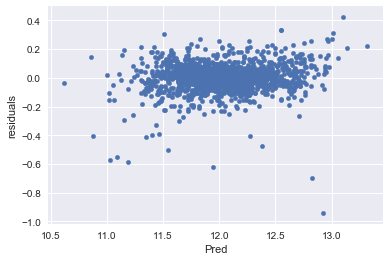

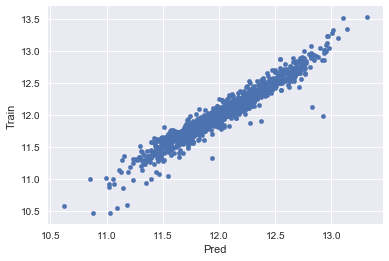

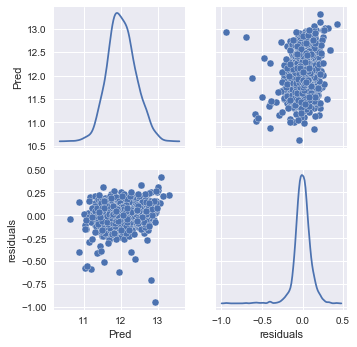

In [13]:
#check how the residuals act on the train set

#prediction_train=L1res.loc['train']['Lasso'].values
#prediction=L1res.loc['test']['Lasso'].values



res = pd.DataFrame({"Pred":prediction.loc['train']['Price'], "Train":Y_train['Price'].values})
res["residuals"] = res["Train"] - res["Pred"]
res.plot(x = "Pred", y = "residuals",kind = "scatter")
res.plot(x = "Pred", y = "Train",kind = "scatter")

g = sns.pairplot(res,x_vars=['Pred','residuals'],y_vars=['Pred','residuals'], diag_kind="kde")

#residuals look quite nice, no clear errors

In [14]:
#seems like the lowest price houses are bit misscalculated, that could be changed
#by not combining the lowest value bin with the following bin before clustering

#submission
submission = pd.DataFrame({
        "Id": list(range(1461,2920)),
        "SalePrice": np.exp(prediction.loc['test']['Price'].values)
    })
submission.to_csv('submission_2.csv', index=False)

#seems like the new variables helped a bit but not so much as I thought,
#probably the variables are quite prone to oferfitting and thus need more tuning
#some of the old dscarded variables should be taken back
#also the predictor parameters need a new round of tuning
#in addition the way of clustering to bins is not probably any near optimal for the task
#since this is not a real competition, I'm not interested in further tuning
#the best scores were 12.845